# Activation Range Supervision

In this notebook, we explored how well the techniques of activation range supervision will perform to networks.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
import time

import os
os.environ['PYTHONHASHSEED']=str(66)

import random
random.seed(66)

np.random.seed(66)
tf.random.set_seed(66)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  

In [2]:
# Get the Fault injection library and modify it to inject 10 bit flips per layer randomly

!git clone https://github.com/DependableSystemsLab/TensorFI2.git
!sed -i -e 's/from src import config/from TensorFI2.src import config/g'  TensorFI2/src/tensorfi2.py
!sed -i -e 's/Mode: single/Mode: multiple/g'  TensorFI2/experiments/layer-states/confFiles/sample.yaml
!sed -i -e 's/Amount: 1$/Amount: 10/g'  TensorFI2/experiments/layer-states/confFiles/sample.yaml


Cloning into 'TensorFI2'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (360/360), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 360 (delta 59), reused 326 (delta 35), pack-reused 0
Receiving objects: 100% (360/360), 50.38 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [3]:
# Find the range of activation values by running a comprehensive set of data through the model and record the activation of each layer. 
def getActivationRange(model,sample):
  print("Getting activation range of the model:")
  for i in range(0,len(model.layers)):
    model_activations = K.function([model.layers[0].input], [model.layers[i].output])
    model_activations_output = model_activations([sample])[0]
    print("Layer",i)
    print("Max",np.amax(model_activations_output))
    print("Min",np.amin(model_activations_output))

## Cifar10

In [22]:
# Create ML Model for train/eval from  boston_housing
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# A simple CNN network to predict the numbers. 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images,test_labels))

#Get Activation Range of the Neurons
getActivationRange(model,train_images[:1000])

from TensorFI2.src import tensorfi2 as tfi

init = random.sample(range(test_images.shape[0]), 20)
ind=[]
# get randomly a set of images that has 100% accuracy
for i in init:
        test_loss, test_acc = model.evaluate(test_images[i:i+1], test_labels[i:i+1], verbose=0)
        if(test_acc == 1.):
                ind.append(i)
#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

# count the number of sdc that occurs for the previous values
sdc = 0.
for i in ind:
    test_loss, test_acc = model.evaluate(test_images[i:i+1], test_labels[i:i+1], verbose=0)
    if(test_acc == 0.):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 1024)             

In [23]:
# Run training with activation range layer

import random
from TensorFI2.src import tensorfi2 as tfi
from tensorflow.python.keras import backend as K
import numpy as np

# Activation layer class that uses the clipper methods mentioned in the paper
class ActivationRange(tf.keras.layers.Layer):
    def __init__(self, ubound,lbound):
        super(ActivationRange, self).__init__()
        self.upper = tf.Variable(initial_value=ubound, trainable=False)
        self.lower = tf.Variable(initial_value=lbound, trainable=False)

    def call(self, inputs):
        #clipper method
        inputs = tf.cast(inputs > self.lower, inputs.dtype) * inputs
        inputs = tf.cast(inputs < self.upper, inputs.dtype) * inputs
        return inputs

model_activation_range = models.Sequential()
model_activation_range.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_activation_range.add(ActivationRange(1.5,0.))
model_activation_range.add(layers.MaxPooling2D((2, 2)))
model_activation_range.add(ActivationRange(1.5,0.))
model_activation_range.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_activation_range.add(ActivationRange(3.2,0.))
model_activation_range.add(layers.MaxPooling2D((2, 2)))
model_activation_range.add(ActivationRange(3.2,0.))
model_activation_range.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_activation_range.add(ActivationRange(5.4,0.))
model_activation_range.add(layers.Flatten())
model_activation_range.add(ActivationRange(5.4,0.))
model_activation_range.add(layers.Dense(64, activation='relu'))
model_activation_range.add(ActivationRange(14.8,0.))
model_activation_range.add(layers.Dense(10))
model_activation_range.summary()

model_activation_range.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_activation_range.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images,test_labels))

from TensorFI2.src import tensorfi2 as tfi

init = random.sample(range(test_images.shape[0]), 20)
ind=[]
# get a small set of inputs that contains 100% prediction accuracy
for i in init:
        test_loss, test_acc = model_activation_range.evaluate(test_images[i:i+1], test_labels[i:i+1], verbose=0)
        if(test_acc == 1.):
                ind.append(i)

#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

#count the number of times sdc happens
sdc = 0.
for i in ind:
    test_loss, test_acc = model_activation_range.evaluate(test_images[i:i+1], test_labels[i:i+1], verbose=0)
    if(test_acc == 0.):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 activation_range_8 (Activat  (None, 30, 30, 32)       2         
 ionRange)                                                       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 activation_range_9 (Activat  (None, 15, 15, 32)       2         
 ionRange)                                                       
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 64)        18496     
                                                      

## Boston Housing

In [26]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = datasets.boston_housing.load_data()

#standardize training data
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
train_features = (x_train - train_mean) / train_std

#standardize testing data
test_features_norm = (x_test - train_mean) / train_std

# a dense layer model for predicting the housing prices
boston_model = models.Sequential()
boston_model.add(layers.Dense(20,activation='relu',input_shape=[len(x_train[0])]))
boston_model.add(layers.Dense(1,activation='relu'))

boston_model.summary()

boston_model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = boston_model.fit(train_features, y_train, epochs=1000, verbose=0, validation_data=(test_features_norm,y_test),
                    callbacks=[early_stop])

rmse_final = np.sqrt(float(history.history['val_mse'][-1]))
print(rmse_final)

#Get Activation Range of the Neurons
getActivationRange(boston_model,train_features[:1000])

from TensorFI2.src import tensorfi2 as tfi

init = random.sample(range(x_test.shape[0]), 20)
ind=[]
# get all data that has less rmse than the average rmse of the test set
for i in init:
        test_mse,_,_ = boston_model.evaluate(test_features_norm[i:i+1],y_test[i:i+1],verbose=0)
        if( np.sqrt(test_mse) < rmse_final):
                ind.append(i)
#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=boston_model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

# count how many times the sdc has occur
sdc = 0.
for i in ind:
    test_mse,_,_ = boston_model.evaluate(test_features_norm[i:i+1],y_test[i:i+1],verbose=0)
    if(np.sqrt(test_mse) > rmse_final):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                280       
                                                                 
 dense_25 (Dense)            (None, 1)                 21        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
4.321133802825243
Getting activation range of the model:
Layer 0
Max 11.05834
Min 0.0
Layer 1
Max 52.788555
Min 4.5785565
SDC Amount: 6.0
SDC Percentage: 0.375


In [28]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
from TensorFI2.src import tensorfi2 as tfi


class ActivationRange(tf.keras.layers.Layer):
    def __init__(self, ubound,lbound):
        super(ActivationRange, self).__init__()
        self.upper = tf.Variable(initial_value=ubound, trainable=False)
        self.lower = tf.Variable(initial_value=lbound, trainable=False)

    def call(self, inputs):
        #clipper method
        inputs = tf.cast(inputs > self.lower, inputs.dtype) * inputs
        inputs = tf.cast(inputs < self.upper, inputs.dtype) * inputs
        return inputs

(x_train, y_train), (x_test, y_test) = datasets.boston_housing.load_data()

#standardlize the training data
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
train_features = (x_train - train_mean) / train_std

#standarlize the testing data
test_features_norm = (x_test - train_mean) / train_std

# same model as above but inserted activation range layer
boston_model = models.Sequential()
boston_model.add(layers.Dense(20,activation='relu',input_shape=[len(x_train[0])]))
boston_model.add(ActivationRange(11.1,0.))
boston_model.add(layers.Dense(1,activation='relu'))

boston_model.summary()

boston_model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = boston_model.fit(train_features, y_train, epochs=1000, verbose=0, validation_data=(test_features_norm,y_test),
                    callbacks=[early_stop])

rmse_final = np.sqrt(float(history.history['val_mse'][-1]))
print(rmse_final)

from TensorFI2.src import tensorfi2 as tfi

init = random.sample(range(x_test.shape[0]), 20)
ind=[]
# get some  data that has less rmse than the average rmse of the test set
for i in init:
        test_mse,_,_ = boston_model.evaluate(test_features_norm[i:i+1],y_test[i:i+1],verbose=0)
        if( np.sqrt(test_mse) < rmse_final):
                ind.append(i)
#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=boston_model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

sdc = 0.
# count how many times the sdc has occur
for i in ind:
    test_mse,_,_ = boston_model.evaluate(test_features_norm[i:i+1],y_test[i:i+1],verbose=0)
    if(np.sqrt(test_mse) > rmse_final):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 20)                280       
                                                                 
 activation_range_16 (Activa  (None, 20)               2         
 tionRange)                                                      
                                                                 
 dense_29 (Dense)            (None, 1)                 21        
                                                                 
Total params: 303
Trainable params: 301
Non-trainable params: 2
_________________________________________________________________
4.644381970700785
SDC Amount: 3.0
SDC Percentage: 0.1875


## IMDB Review

In [42]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
#Encode the data with a vocab_size of 1000
encoder = layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# use a bidirectional LSTM layer with embedding for setiment prediction
imdb_model = models.Sequential()
imdb_model.add(encoder)
imdb_model.add(layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True))
imdb_model.add(layers.Bidirectional(layers.LSTM(64)))
imdb_model.add(layers.Dense(64, activation='relu'))
imdb_model.add(layers.Dense(1))

imdb_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
imdb_model.summary()

history = imdb_model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

testing=[]
for x,y in test_dataset:
  testing.append(x)
  break

getActivationRange(imdb_model,testing[0])

from TensorFI2.src import tensorfi2 as tfi

init = range(0,20)
ind=[]
# get some inputs that have correct predictions
for i in init:
  test_dataset = dataset['test'].shuffle(BUFFER_SIZE).take(1)
  for x,y in test_dataset:
    test_acc = imdb_model.predict(np.array([(x.numpy())]))
    if((test_acc >= 0 and y.numpy()==1)or(test_acc <0 and y.numpy()==0)):
            ind.append(np.array([(x.numpy())]))

#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=imdb_model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

#count the number of times the predictions turned incorrect. 
sdc = 0.
for i in ind:
    test_acc = imdb_model.predict(i)
    if(not ((test_acc >= 0 and y.numpy()==1)or(test_acc <0 and y.numpy()==0))):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-t

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import backend as K
import tensorflow_datasets as tfds
from TensorFI2.src import tensorfi2 as tfi


class ActivationRange(tf.keras.layers.Layer):
    def __init__(self, ubound,lbound):
        super(ActivationRange, self).__init__()
        self.upper = tf.Variable(initial_value=ubound, trainable=False)
        self.lower = tf.Variable(initial_value=lbound, trainable=False)

    def call(self, inputs):
        #clipper method
        inputs = tf.cast(inputs > self.lower, inputs.dtype) * inputs
        inputs = tf.cast(inputs < self.upper, inputs.dtype) * inputs
        return inputs

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

imdb_model = models.Sequential()
imdb_model.add(encoder)
imdb_model.add(layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True))
imdb_model.add(ActivationRange(0.17,-0.19))
imdb_model.add(layers.Bidirectional(layers.LSTM(64)))
imdb_model.add(ActivationRange(0.53,-0.53))
imdb_model.add(layers.Dense(64, activation='relu'))
imdb_model.add(ActivationRange(1.4,0.))
imdb_model.add(layers.Dense(1))

imdb_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
imdb_model.summary()

history = imdb_model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

init = range(0,20)
ind=[]

for i in init:
  test_dataset = dataset['test'].shuffle(BUFFER_SIZE).take(1)
  for x,y in test_dataset:
    test_acc = imdb_model.predict(np.array([(x.numpy())]))
    if((test_acc >= 0 and y.numpy()==1)or(test_acc <0 and y.numpy()==0)):
            ind.append(np.array([(x.numpy())]))

#layer-states insert with multilayer bitflips at a rate of 10 %
tfi.inject(model=imdb_model,confFile='/content/TensorFI2/experiments/layer-states/confFiles/sample.yaml')

sdc = 0.
for i in ind:
    test_acc = imdb_model.predict(i)
    if(not ((test_acc >= 0 and y.numpy()==1)or(test_acc <0 and y.numpy()==0))):
        sdc = sdc + 1.
print("SDC Amount:",sdc)
print("SDC Percentage:", sdc/len(ind))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteET1P2S/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteET1P2S/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteET1P2S/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 activation_range (Activatio  (None, None, 64)         2         
 nRange)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                            

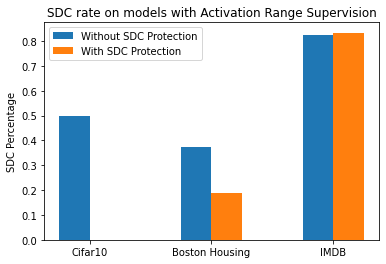

In [1]:
# Plot the SDC Percentage values 
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
models = ['Cifar10','Boston Housing','IMDB']
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
ax.bar(x - width/2,[0.5,0.375,0.8235294117647058],width,label="Without SDC Protection")
ax.bar(x + width/2,[0.,0.1875,0.8333333333333334],width,label="With SDC Protection")
ax.set_ylabel('SDC Percentage')
ax.set_title('SDC rate on models with Activation Range Supervision')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.show()
